# A Random Latent Clique Lifting from Graphs to Simplicial Complexes

**TL;DR** We propose a lifting that ensures both 1) small-world property and 2) edge/cell sparsity. The combination of these two properties are very attractive for Topological Deep Learning (TDL) because it ensures computational efficiency due to the reduced number of higher-order connections while only a small number of message-passing layers connects any two nodes.

**Background**. A graph is **sparse** if their number of edges grows proportional to the number of nodes. Many real-world graphs are sparse but they contain **many densely connected subgraphs** and exhibit high clustering coefficients.  Moreover, such real-world graphs frequently exhibit the **small-world property**, wherin any two nodes are connected by a short path of length proportional to the logarithm of the number of nodes. For instance, these are well-known properties of social networks, biological networks, and the Internet.

**Contributions**. In this notebook, we present a novel random lifting procedure from graphs to simplicial complexes. The procedure is based on a relatively recent proposed Bayesian nonparametric random graph model for random clique covers (Williamson & Tec, 2020). Specifically, the model is able to learn latent clique complexes consistent with the input graph. The model is guaranteed to capture power law degree distribution, global sparsity, and non-vanishing local clustering coefficient. Its small-world property is also guaranteed, which is a very attractive property for Topological Deep Learning (TDL).
***

In the original work [1], the distribution has been used as a prior on an observed input graph. In particular, in the Bayesian setting, the model is useful to obtain a distribution on latent **clique complexes**, i.e. a specific class of **simplicial complexes**, whose 1-skeleton structural properties are consistent with the ones of the input graph used to compute the likelihood. Indeed, one of the features of the posterior distribution from which the latent complex is sampled is that the set of latent 1-simplices (edges) is a superset of the set of edges of the input graph.

***

In the context of **Topological Deep Learning** [2][3] and the very recently emerged paradigm of **Latent Topology Inference** (LTI) [4], it is natural to look at the model in [1] as a novel LTI method able to infer a **random latent simplicial complex** from an input graph. Or, in other words, to use [1] as a novel random lifting procedure from graphs to simplicial complexes.

Next, we provide a quick introduction to the model in [1]. For a more in-depth exposition, please refer to the paper. To the best of our knowledge, this is the first random lifting procedure relying on Bayesian arguments.

To summarize, this is:
- a **non-deterministic** lifting,
- **not present** in the literature as a lifting prcedure,
- **based on connectivity**,
-  **modifying** the initial connectivity of the graph by adding edges (thus, this can be also considered as a graph rewiring method).

# The Random Clique Cover Model

Let $G=(V,E)$ be a graph with $V$ the set of vertices and $E$ the set of edges. Denote the numer of nodes as $N=|V|$. A *clique cover* can be described as a matrix $Z$ of size $K \times N$ where $K$ is the number of cliques such that $Z_{k, i} = 1$ if node $i$ is in clique $k$ and $Z_{k, i} = 0$ otherwise. The Random Clique Cover (RCC) Model, defined in [1], is a probabilistic model for the matrix $Z$. This matrix can have an infinite number of rows and columns, but only a finite number of them will be active. The model is based on the Indian Buffet Process (IBP), which is a distribution over binary matrices with a possibly infinite number of rows and columns, or more specifically, the Stable Beta IBP as described in [5]. While the mathematics behind the IBP are complex,  the model admits a highly intuitive representation describe below.

First, recall that a clique is a fully connected subset of vertices. Therefore, a clique cover $Z$ induces an adjacency matrix by the formula $A = min(Z^T Z - diag(Z^T Z), 1)$, where $min$ is the element-wise minimum. The IBP model can be described recursively as follows:

Conditional on $Z_1, Z_2, ..., Z_{K-1}$, where $Z_j$ is the $j$-th row of $Z$. Then, $Z_K$ is drawn as follows:

1. $Z_K$ will contain new unobserved nodes according to a distribution\:
$$Z_K | Z_1, Z_2, ..., Z_{K-1}\sim \text{Poisson}\left(\alpha \frac{\Gamma(1 + c)\Gamma(N + c + \sigma - 1)}{\Gamma(N + \sigma)\Gamma(c + \sigma)}\right)$$
2. The probability that a previously observed node $n$ will belong to $Z_K$ is proportional to how many cliques it is already in. Specifically, letting $m_i=\sum_{j=1}^{k=K-1} Z_{j, i}$, then 
$$P(Z_{K,i}=1|Z_1, Z_2, ..., Z_{K-1}) = \frac{m_i + \sigma}{K + c - 1}.$$

**The last expresssion is highly inuitive in the sense that the number of cliques that a node will appear in is proportional to the number of cliques it is already in.**

The RCC model depends on four parameters $\alpha, c, \sigma, \pi$. The first three parameters are part of the IBP. Explaining them in detail is beyond the scope of this notebook. However, the reader may see [5]. Fortunately,  the learned (posterior) values of $\alpha, \sigma, c$ are strongly determined by the data itself. In contrast $\pi$ is approximately the probability that an edge is missing from the graph. Generally, the lower $\pi$ is, the lower the number of cliques will be and the less interconnected the nodes of the clique will be.

Impotantly, by leveraging the poissiblity of latent inferred edges, one will superimpose the small-world property on the graph. 

<!-- Williamson & Tec (2020) introduce a Bayesian nonparametric graph model that addresses the challenge of modeling large real-world graphs, which are typically sparse but contain many densely connected subgraphs. Specifically, the model is the first to introduce a fully probabilistic (random) framework that allows for exchangeability that simultaneously allows for global sparsity and local density, including high clustering coefficients and power-law degree distributions. The model is based on random edge clique covers, which are collections of cliques (fully connected subsets of vertices) that cover all edges in the graph. Additionally, the model allows for latent unobsered edges which results in latent cliques which may not be present in the observed graph. 

The proposed model explicitly represents graphs as collections of cliques, or fully connected subsets of vertices, selected using a nonparametric feature selection model, such as the stable beta Indian buffet process. This approach allows the model to exhibit local density and non-zero local clustering coefficients while maintaining global sparsity4. 

In summary, th emodel will learn a small-world graph on top of the existing graph, by infilling the graph with latent edges if necessary. It is possible to assign a prior distribution to control the prior belief of the proporiton of latent edges in the graph. -->

### Imports and utilities

In [1]:
%cd challenge-icml-2024

/content/challenge-icml-2024


In [2]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to specify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [3]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


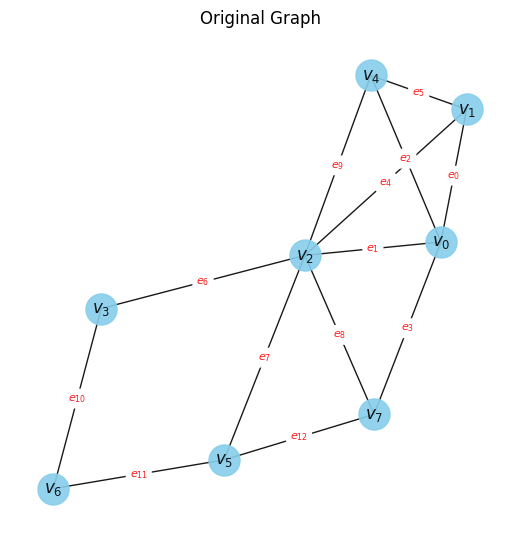

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [4]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the random clique lifting.

For simplicial complexes creating a lifting involves creating a `SimplicialComplex` object from topomodelx and adding simplices to it using the method `add_simplices_from`. The `SimplicialComplex` class then takes care of creating all the needed matrices.

Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`.

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

In [5]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2simplicial/latentclique_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2simplicial/latentclique_lifting:

{'transform_type': 'lifting',
 'transform_name': 'LatentCliqueLifting',
 'complex_dim': 3,
 'preserve_edge_attr': False,
 'signed': True,
 'feature_lifting': 'ProjectionSum',
 'edge_prob_mean': 0.95,
 'edge_prob_var': 0.0004}


We than apply the transform via our `PreProcesor`:

Processing...
/content/challenge-icml-2024/modules/transforms/liftings/graph2simplicial/latentclique_lifting.py:72: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
Done!



Dataset only contains 1 sample:


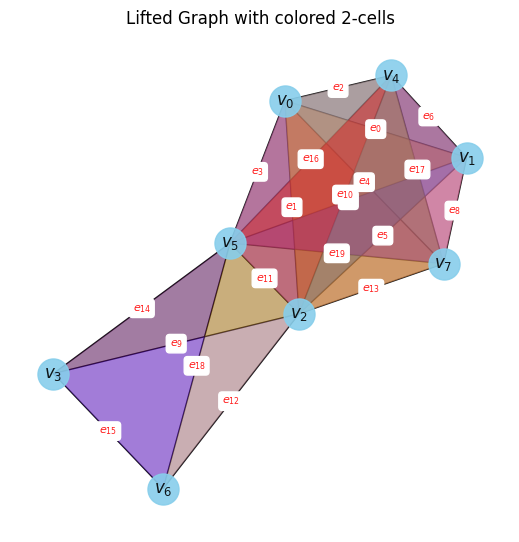

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 20 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 24 2-cells.
 - The 2-cells have features dimension 1



In [7]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [8]:
from modules.models.simplicial.san import SANModel

model_type = "simplicial"
model_id = "san"
model_config = load_model_config(model_type, model_id)

model = SANModel(model_config, dataset_config)


Model configuration for simplicial SAN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'n_filters': 2,
 'order_harmonic': 5,
 'epsilon_harmonic': 0.1}


In [9]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors.

# References

***
[[1]](http://proceedings.mlr.press/v115/williamson20a/williamson20a.pdf) Williamson, Sinead A., and Mauricio Tec. "Random clique covers for graphs with local density and global sparsity." Uncertainty in Artificial Intelligence (UAI). PMLR, 2020.

[[2]](https://arxiv.org/abs/2402.08871)  Papamarkou, Theodore, et al. "Position paper: Challenges and opportunities in topological deep learning." arXiv preprint arXiv:2402.08871 (2024).

[[3]](https://arxiv.org/abs/2206.00606) Hajij, Mustafa, et al. "Topological deep learning: Going beyond graph data." arXiv preprint arXiv:2206.00606 (2022).

[[4]](https://openreview.net/forum?id=0JsRZEGZ7L) Battiloro, Claudio, et al. "From latent graph to latent topology inference: Differentiable cell complex module." The Twelfth International Conference on Learning Representations (ICLR), 2024.

[[5]](https://papers.nips.cc/paper_files/paper/2009/hash/f1b6f2857fb6d44dd73c7041e0aa0f19-Abstract.html) Teh, Yee Whye, and Dilan Görür. "Indian Buffet Processes with Power-law Behavior." Advances in neural information processing systems. 2009.
***
